In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

tf.__version__
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# 기본 블록 구성하기 
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

# ResNet 기본 블록 구성하기
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

# ResNet 모델 구성하기
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model


    
# PlainNet 모델 구성하기
def build_plainnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
   
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Activation('relu')(x)

    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Activation('relu')(x)
    

    return x

# Plainnet 모델 구성하기
def build_plainnet(input_shape=(224,224,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='PlainNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if not is_50:
        name =  'PlainNet_34'

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plainnet_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [3]:
import urllib3
urllib3.disable_warnings()

# cats_vs_dogs 데이터셋이 tensorflow API 오류로 불러오지 못하는 경우가 있을 경우
# 로드하기 전에 이것을 추가해서 새 URL을 설정할 수 있습니다.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True, # 데이터가 튜플로 반환, False는 dictionarty형태로 반환
    with_info=True, # 데이터의 정보를 같이 반환한다.
)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-10-19 13:02:56.424145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-19 13:02:56.424288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# 데이터 전처리하기(정규화 함수 만들기)
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def model_fit(model):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=0.001),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    return history

BATCH_SIZE = 32
EPOCH = 5

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [5]:
# resnet_34 학습하기
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

resnet_34_history = model_fit(resnet_34)
# resnet_50 학습하기
resnet_50 = build_resnet(input_shape=(224, 224, 3),  
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

resnet_50_history = model_fit(resnet_50)

plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')


plain_34_history = model_fit(plain_34)

# plain_50 학습하기
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')


plain_50_history = model_fit(plain_50)


Epoch 1/5


/Users/jamesyu/Library/Python/3.9/lib/python/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-10-19 13:03:13.995796: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-19 13:03:13.997722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 2:41 - loss: 3.0369 - accuracy: 0.5179

 38/581 [>.............................] - ETA: 2:38 - loss: 2.9090 - accuracy: 0.5222

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 2:16 - loss: 2.5934 - accuracy: 0.5595

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:16 - loss: 2.3812 - accuracy: 0.5959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:13 - loss: 2.3715 - accuracy: 0.5980

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:09 - loss: 2.3642 - accuracy: 0.5977

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 1:01 - loss: 2.3441 - accuracy: 0.6003

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 59s - loss: 2.3408 - accuracy: 0.6002 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 1s - loss: 2.2021 - accuracy: 0.6180

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1991 - accuracy: 0.6186

2022-10-19 13:06:15.931092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 198s 322ms/step - loss: 2.1991 - accuracy: 0.6186 - val_loss: 1.8272 - val_accuracy: 0.6589
Epoch 2/5
 28/581 [>.............................] - ETA: 2:43 - loss: 1.7752 - accuracy: 0.6819

 40/581 [=>............................] - ETA: 2:40 - loss: 1.7729 - accuracy: 0.6852

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:17 - loss: 1.7271 - accuracy: 0.6916

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:16 - loss: 1.6210 - accuracy: 0.6959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:13 - loss: 1.6142 - accuracy: 0.6962

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:09 - loss: 1.6066 - accuracy: 0.6982

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 1:01 - loss: 1.5910 - accuracy: 0.7014

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 59s - loss: 1.5869 - accuracy: 0.7014

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.4865 - accuracy: 0.7145

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4864 - accuracy: 0.7141

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 185s 318ms/step - loss: 1.4864 - accuracy: 0.7141 - val_loss: 1.4226 - val_accuracy: 0.5316
Epoch 3/5
 29/581 [>.............................] - ETA: 2:40 - loss: 1.1970 - accuracy: 0.7713

 42/581 [=>............................] - ETA: 2:36 - loss: 1.1911 - accuracy: 0.7639

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:16 - loss: 1.1743 - accuracy: 0.7545

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:16 - loss: 1.1071 - accuracy: 0.7591

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:13 - loss: 1.1042 - accuracy: 0.7600

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:09 - loss: 1.1000 - accuracy: 0.7599

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:00 - loss: 1.0912 - accuracy: 0.7619

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 59s - loss: 1.0898 - accuracy: 0.7614

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.0331 - accuracy: 0.7680

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 185s 318ms/step - loss: 1.0331 - accuracy: 0.7680 - val_loss: 1.2769 - val_accuracy: 0.5924
Epoch 4/5
  1/581 [..............................] - ETA: 2:54 - loss: 0.8257 - accuracy: 0.9062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:42 - loss: 0.8649 - accuracy: 0.7969

 41/581 [=>............................] - ETA: 2:39 - loss: 0.8560 - accuracy: 0.8018

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:17 - loss: 0.8510 - accuracy: 0.7943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:16 - loss: 0.8041 - accuracy: 0.8047

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:12 - loss: 0.8014 - accuracy: 0.8055

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:10 - loss: 0.8012 - accuracy: 0.8054

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 1:01 - loss: 0.7940 - accuracy: 0.8071

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 59s - loss: 0.7942 - accuracy: 0.8069 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.8139

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 187s 321ms/step - loss: 0.7613 - accuracy: 0.8139 - val_loss: 0.8436 - val_accuracy: 0.7115
Epoch 5/5
  2/581 [..............................] - ETA: 2:50 - loss: 0.6354 - accuracy: 0.7812

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/581 [>.............................] - ETA: 2:42 - loss: 0.6553 - accuracy: 0.8357

 44/581 [=>............................] - ETA: 2:38 - loss: 0.6796 - accuracy: 0.8253

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:17 - loss: 0.6695 - accuracy: 0.8258

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:16 - loss: 0.6362 - accuracy: 0.8357

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:12 - loss: 0.6341 - accuracy: 0.8367

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:09 - loss: 0.6309 - accuracy: 0.8382

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:01 - loss: 0.6302 - accuracy: 0.8376

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 59s - loss: 0.6302 - accuracy: 0.8379

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.8463

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 186s 320ms/step - loss: 0.6043 - accuracy: 0.8463 - val_loss: 1.9576 - val_accuracy: 0.5548
Epoch 1/5


2022-10-19 13:18:56.207712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 2:09 - loss: 6.5584 - accuracy: 0.5420

 38/581 [>.............................] - ETA: 2:03 - loss: 6.4458 - accuracy: 0.5502

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:43 - loss: 6.0673 - accuracy: 0.5851

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 56s - loss: 5.3908 - accuracy: 0.6112

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 53s - loss: 5.3571 - accuracy: 0.6135

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 51s - loss: 5.3236 - accuracy: 0.6172

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 45s - loss: 5.2438 - accuracy: 0.6169

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 43s - loss: 5.2237 - accuracy: 0.6166

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 4.6942 - accuracy: 0.6379

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 4.6917 - accuracy: 0.6381

2022-10-19 13:21:09.580024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 159s 260ms/step - loss: 4.6917 - accuracy: 0.6381 - val_loss: 3.4927 - val_accuracy: 0.6074
Epoch 2/5
 29/581 [>.............................] - ETA: 1:52 - loss: 3.2192 - accuracy: 0.7047

 38/581 [>.............................] - ETA: 1:51 - loss: 3.2249 - accuracy: 0.6916

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:40 - loss: 3.0826 - accuracy: 0.7065

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 55s - loss: 2.7766 - accuracy: 0.7219

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 53s - loss: 2.7621 - accuracy: 0.7210

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 50s - loss: 2.7463 - accuracy: 0.7214

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 44s - loss: 2.7133 - accuracy: 0.7231

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 42s - loss: 2.7060 - accuracy: 0.7233

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 2.4927 - accuracy: 0.7255

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.4905 - accuracy: 0.7255

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 150s 258ms/step - loss: 2.4905 - accuracy: 0.7255 - val_loss: 1.9651 - val_accuracy: 0.7394
Epoch 3/5
 30/581 [>.............................] - ETA: 1:57 - loss: 1.8803 - accuracy: 0.7677

 41/581 [=>............................] - ETA: 1:52 - loss: 1.8675 - accuracy: 0.7706

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:37 - loss: 1.8260 - accuracy: 0.7649

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 54s - loss: 1.7059 - accuracy: 0.7675

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 52s - loss: 1.6985 - accuracy: 0.7682

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 49s - loss: 1.6917 - accuracy: 0.7692

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 43s - loss: 1.6767 - accuracy: 0.7713

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 42s - loss: 1.6726 - accuracy: 0.7714

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.5770 - accuracy: 0.7784

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 147s 253ms/step - loss: 1.5770 - accuracy: 0.7784 - val_loss: 2.1704 - val_accuracy: 0.5489
Epoch 4/5
  1/581 [..............................] - ETA: 1:57 - loss: 1.5269 - accuracy: 0.6250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/581 [>.............................] - ETA: 1:54 - loss: 1.3551 - accuracy: 0.7621

 44/581 [=>............................] - ETA: 1:52 - loss: 1.3310 - accuracy: 0.7763

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:38 - loss: 1.3036 - accuracy: 0.7905

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 54s - loss: 1.2541 - accuracy: 0.7987

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 51s - loss: 1.2513 - accuracy: 0.7993

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 49s - loss: 1.2469 - accuracy: 0.7999

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 44s - loss: 1.2408 - accuracy: 0.7994

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 42s - loss: 1.2383 - accuracy: 0.7996

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1832 - accuracy: 0.8059

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 147s 254ms/step - loss: 1.1832 - accuracy: 0.8059 - val_loss: 1.2519 - val_accuracy: 0.6817
Epoch 5/5
  1/581 [..............................] - ETA: 1:57 - loss: 0.9380 - accuracy: 0.8438

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:56 - loss: 1.0563 - accuracy: 0.7966

 44/581 [=>............................] - ETA: 1:52 - loss: 1.0395 - accuracy: 0.8042

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:37 - loss: 0.9939 - accuracy: 0.8316

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 53s - loss: 0.9758 - accuracy: 0.8368

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 51s - loss: 0.9718 - accuracy: 0.8379

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 49s - loss: 0.9685 - accuracy: 0.8388

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 43s - loss: 0.9644 - accuracy: 0.8387

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 42s - loss: 0.9649 - accuracy: 0.8379

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9390 - accuracy: 0.8406

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 145s 249ms/step - loss: 0.9390 - accuracy: 0.8406 - val_loss: 1.0388 - val_accuracy: 0.8216
Epoch 1/5


2022-10-19 13:31:24.645661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 2:43 - loss: 2.3340 - accuracy: 0.4978

 37/581 [>.............................] - ETA: 2:39 - loss: 2.3063 - accuracy: 0.5025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 2:14 - loss: 2.1607 - accuracy: 0.4967

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:14 - loss: 1.8533 - accuracy: 0.5041

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 1:11 - loss: 1.8399 - accuracy: 0.5030

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:07 - loss: 1.8238 - accuracy: 0.5025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 1:00 - loss: 1.7936 - accuracy: 0.5041

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 58s - loss: 1.7869 - accuracy: 0.5040

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.6140 - accuracy: 0.5094

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.6133 - accuracy: 0.5097

2022-10-19 13:34:14.584406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 192s 322ms/step - loss: 1.6133 - accuracy: 0.5097 - val_loss: 3.5006 - val_accuracy: 0.5082
Epoch 2/5
 29/581 [>.............................] - ETA: 2:38 - loss: 1.1824 - accuracy: 0.5485

 39/581 [=>............................] - ETA: 2:36 - loss: 1.1810 - accuracy: 0.5409

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 2:14 - loss: 1.1517 - accuracy: 0.5404

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:14 - loss: 1.0919 - accuracy: 0.5432

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:11 - loss: 1.0897 - accuracy: 0.5412

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:07 - loss: 1.0868 - accuracy: 0.5425

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 59s - loss: 1.0810 - accuracy: 0.5442 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 57s - loss: 1.0796 - accuracy: 0.5454

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 1.0396 - accuracy: 0.5522

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.0395 - accuracy: 0.5521

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 186s 321ms/step - loss: 1.0395 - accuracy: 0.5521 - val_loss: 0.9430 - val_accuracy: 0.5405
Epoch 3/5
 26/581 [>.............................] - ETA: 2:39 - loss: 0.9229 - accuracy: 0.5865

 39/581 [=>............................] - ETA: 2:34 - loss: 0.9241 - accuracy: 0.5849

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:13 - loss: 0.9418 - accuracy: 0.5424

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:13 - loss: 0.9527 - accuracy: 0.5243

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:11 - loss: 0.9529 - accuracy: 0.5222

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:06 - loss: 0.9527 - accuracy: 0.5222

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 59s - loss: 0.9522 - accuracy: 0.5248

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 57s - loss: 0.9521 - accuracy: 0.5236

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9366 - accuracy: 0.5315

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 185s 318ms/step - loss: 0.9366 - accuracy: 0.5315 - val_loss: 0.8862 - val_accuracy: 0.5030
Epoch 4/5


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:35 - loss: 0.8822 - accuracy: 0.5283

 41/581 [=>............................] - ETA: 2:32 - loss: 0.8817 - accuracy: 0.5274

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:10 - loss: 0.8707 - accuracy: 0.5239

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:13 - loss: 0.8654 - accuracy: 0.5266

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:09 - loss: 0.8652 - accuracy: 0.5263

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:06 - loss: 0.8654 - accuracy: 0.5239

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 59s - loss: 0.8651 - accuracy: 0.5239

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 57s - loss: 0.8649 - accuracy: 0.5235

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8541 - accuracy: 0.5257

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 183s 316ms/step - loss: 0.8541 - accuracy: 0.5257 - val_loss: 0.9146 - val_accuracy: 0.5123
Epoch 5/5
  2/581 [..............................] - ETA: 2:41 - loss: 0.8402 - accuracy: 0.5625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 2:37 - loss: 0.8333 - accuracy: 0.5125

 42/581 [=>............................] - ETA: 2:34 - loss: 0.8284 - accuracy: 0.5298

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:12 - loss: 0.8283 - accuracy: 0.5300

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:13 - loss: 0.8317 - accuracy: 0.5168

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:09 - loss: 0.8309 - accuracy: 0.5166

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:06 - loss: 0.8299 - accuracy: 0.5174

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 58s - loss: 0.8278 - accuracy: 0.5164

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 56s - loss: 0.8271 - accuracy: 0.5174

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8174 - accuracy: 0.5182

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 185s 319ms/step - loss: 0.8174 - accuracy: 0.5182 - val_loss: 2.8657 - val_accuracy: 0.5170
Epoch 1/5


2022-10-19 13:46:58.522484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 2:06 - loss: 5.3234 - accuracy: 0.4938

 38/581 [>.............................] - ETA: 2:03 - loss: 5.3021 - accuracy: 0.4893

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:45 - loss: 5.0447 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:00 - loss: 4.3722 - accuracy: 0.4959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 58s - loss: 4.3452 - accuracy: 0.4963

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 55s - loss: 4.3108 - accuracy: 0.4969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 48s - loss: 4.2421 - accuracy: 0.4972

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 47s - loss: 4.2273 - accuracy: 0.4968

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 3.8086 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 3.8069 - accuracy: 0.4985

2022-10-19 13:49:21.566401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 181s 299ms/step - loss: 3.8069 - accuracy: 0.4985 - val_loss: 2.8158 - val_accuracy: 0.5006
Epoch 2/5
 29/581 [>.............................] - ETA: 2:28 - loss: 2.7675 - accuracy: 0.5011

 40/581 [=>............................] - ETA: 2:22 - loss: 2.7558 - accuracy: 0.5031

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:01 - loss: 2.6915 - accuracy: 0.5022

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:04 - loss: 2.5334 - accuracy: 0.4986

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:01 - loss: 2.5266 - accuracy: 0.4980

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 58s - loss: 2.5183 - accuracy: 0.4989

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 52s - loss: 2.5004 - accuracy: 0.4978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 50s - loss: 2.4964 - accuracy: 0.4993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.3887 - accuracy: 0.4950

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3881 - accuracy: 0.4952

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 184s 317ms/step - loss: 2.3881 - accuracy: 0.4952 - val_loss: 2.1084 - val_accuracy: 0.4765
Epoch 3/5
 29/581 [>.............................] - ETA: 2:29 - loss: 2.0637 - accuracy: 0.5194

 42/581 [=>............................] - ETA: 2:19 - loss: 2.0613 - accuracy: 0.5074

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:55 - loss: 2.0348 - accuracy: 0.4987

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:03 - loss: 1.9807 - accuracy: 0.5100

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:01 - loss: 1.9776 - accuracy: 0.5096

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 58s - loss: 1.9740 - accuracy: 0.5103

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 52s - loss: 1.9652 - accuracy: 0.5130

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 50s - loss: 1.9624 - accuracy: 0.5123

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.9159 - accuracy: 0.5206

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 177s 304ms/step - loss: 1.9159 - accuracy: 0.5206 - val_loss: 1.7594 - val_accuracy: 0.4916
Epoch 4/5
 31/581 [>.............................] - ETA: 2:05 - loss: 1.7249 - accuracy: 0.5615

 43/581 [=>............................] - ETA: 2:03 - loss: 1.7191 - accuracy: 0.5821

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:55 - loss: 1.7017 - accuracy: 0.5510

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:05 - loss: 1.6700 - accuracy: 0.5332

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:02 - loss: 1.6690 - accuracy: 0.5336

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 59s - loss: 1.6673 - accuracy: 0.5324

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 53s - loss: 1.6602 - accuracy: 0.5304

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 51s - loss: 1.6585 - accuracy: 0.5300

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.6179 - accuracy: 0.5326

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 184s 316ms/step - loss: 1.6179 - accuracy: 0.5326 - val_loss: 1.5321 - val_accuracy: 0.4957
Epoch 5/5
  3/581 [..............................] - ETA: 1:55 - loss: 1.4859 - accuracy: 0.5938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 2:06 - loss: 1.5049 - accuracy: 0.5625

 42/581 [=>............................] - ETA: 2:10 - loss: 1.5063 - accuracy: 0.5484

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:52 - loss: 1.5145 - accuracy: 0.5481

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:05 - loss: 1.4969 - accuracy: 0.5425

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:01 - loss: 1.4951 - accuracy: 0.5440

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 58s - loss: 1.4933 - accuracy: 0.5438

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 51s - loss: 1.4896 - accuracy: 0.5447

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 49s - loss: 1.4884 - accuracy: 0.5461

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4544 - accuracy: 0.5479

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 184s 317ms/step - loss: 1.4544 - accuracy: 0.5479 - val_loss: 1.3787 - val_accuracy: 0.4814


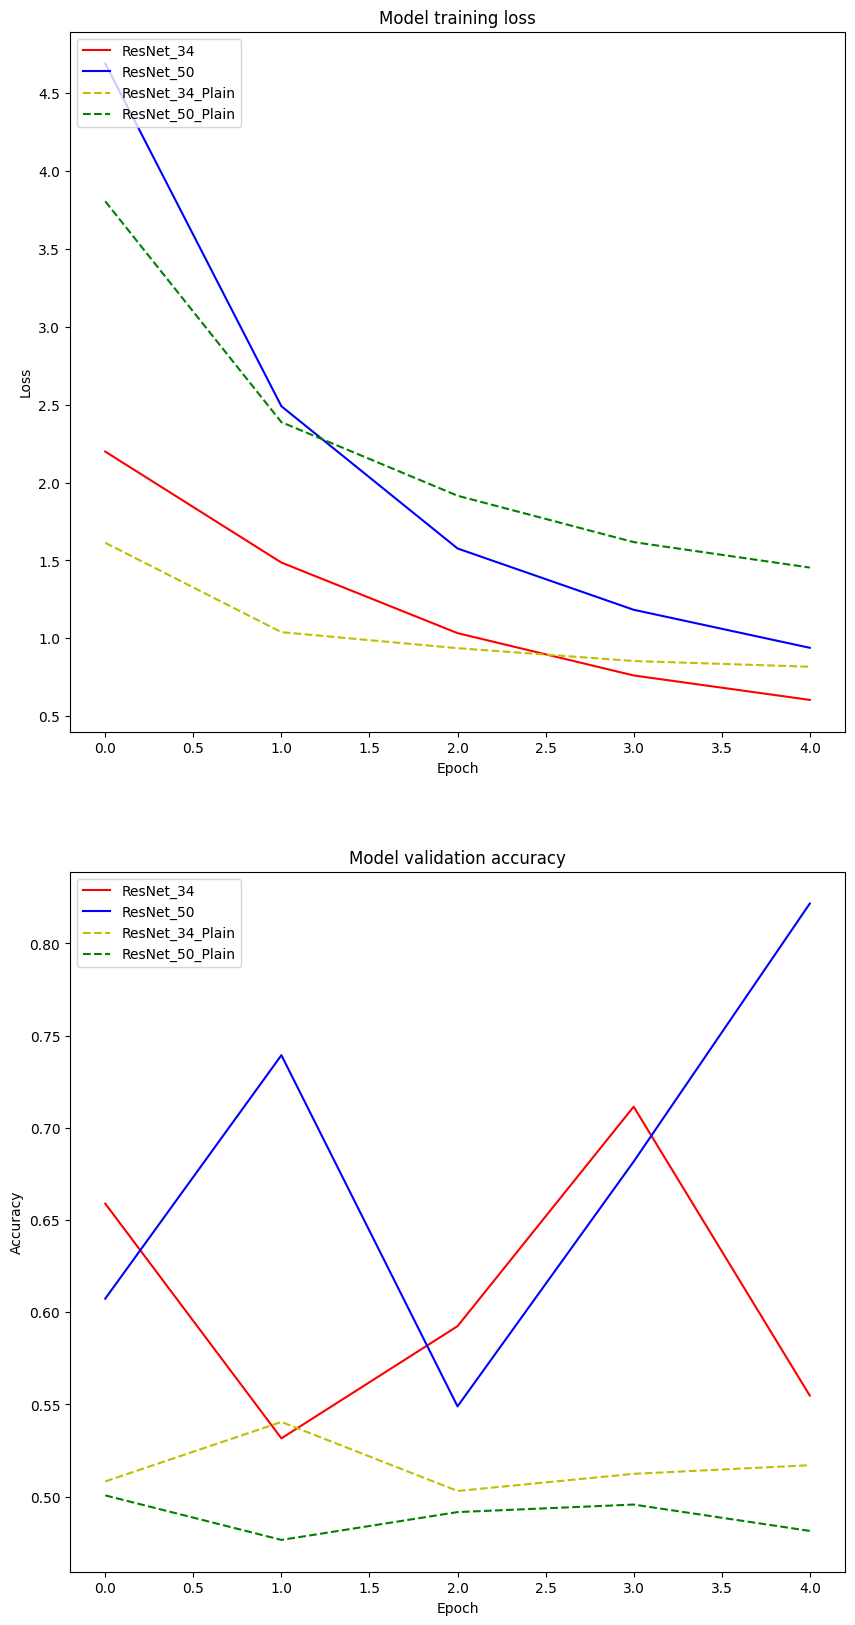

In [6]:
# 시각화하여 결과 비교하기
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)

plt.plot(resnet_34_history.history['loss'], 'r')
plt.plot(resnet_50_history.history['loss'], 'b')
plt.plot(plain_34_history.history['loss'], 'y', linestyle='dashed')
plt.plot(plain_50_history.history['loss'], 'g', linestyle='dashed')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(resnet_34_history.history['val_accuracy'], 'r')
plt.plot(resnet_50_history.history['val_accuracy'], 'b')
plt.plot(plain_34_history.history['val_accuracy'], 'y', linestyle='dashed')
plt.plot(plain_50_history.history['val_accuracy'], 'g', linestyle='dashed')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')
plt.show()